# CS 6140 Machine Learning: Assignment - 1 (Total Points: 100)
## Prof. Ahmad Uzair

### Q1. Decision Tree Classifier (50 points)

In [16]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
data = pd.read_csv('data.csv')
print('Data shape: ', data.shape)

X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, random_state = 88, shuffle = True)

Data shape:  (150, 5)


### Q1.1 Growing Decision Trees from scratch (40 points)

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure. 

Use the data.csv dataset for this particular question. The dataset should be uploaded on Canvas with Assignment 1. Split the dataset into training and test data and calculate testing accuracy.



In [18]:
class Node:

    def __init__(self, feature_index = None, threshold = None, left = None, right = None, info_gain = None, value = None):
        # Start code here
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # for leaf node
        self.value = value
    # End code here

In [19]:
class DecisionTreeClassifier:
    def __init__(self, min_samples_split = 2, max_depth = 2):
        # Initialize the root of the decision tree to traverse through the decision tree to None
        self.root = None
        # initialize the stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth = 0):
        """
        This will be a recursive function to build the decision tree.
        dataset: The data that you will be using for your assignment
        curr_depth: Current depth of the tree
        Returns the leaf node
        """
        # Separate the features and targets into two variables X and Y
        X = dataset[:, :-1]
        Y = dataset[:, -1]

        # Extract the number of samples and number of features
        num_samples = X.shape[0]
        num_features = X.shape[1]

        # split until stopping conditions are met
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # print(best_split)
            dataset_left = self.build_tree(best_split['dataset_left'], curr_depth + 1)
            dataset_right = self.build_tree(best_split['dataset_right'], curr_depth + 1)
            return Node(best_split['feature_idx'], best_split['threshold'], dataset_left, dataset_right, best_split['ig'])

        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)

        # return the leaf node
        return Node(value = leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        """
        Function to find out the best split
        dataset: input data
        num_samples: Number of samples present in the dataset
        num_features: Number of features in the dataset
        Returns the best split
        """

        # dictionary to store the best split
        best_split = {}
        max_ig = float('-inf')

        # loop over all the features in the data
        for feature_idx in range(num_features):
            feature_col = dataset[:, feature_idx]
            # Use the distinct value of current feature as candidates of threshold
            for threshold in np.unique(feature_col):
                dataset_left, dataset_right = self.split(dataset, feature_idx, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y_parent, y_left, y_right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_ig = self.information_gain(y_parent, y_left, y_right)
                    if curr_ig > max_ig:
                        max_ig = curr_ig
                        best_split['feature_idx'] = feature_idx
                        best_split['threshold'] = threshold
                        best_split['dataset_left'] = dataset_left
                        best_split['dataset_right'] = dataset_right
                        best_split['ig'] = max_ig

        return best_split

    def split(self, dataset, feature_index, threshold):
        """
        Function to split the data to the left child and right child in the decision tree
        dataset: input data
        feature_index: feature index used to locate the index of the feature in a particular row in the dataset
        threshold: threshold value based on which the split will be calculated
        Returns the left and right data values from the dataset
        """
        # Hint: Use list comprehension to distinguish which values would be present in left and right
        # subtree on the basis of threshold
        dataset_left = np.array([instance for instance in dataset if instance[feature_index] <= threshold])
        dataset_right = np.array([instance for instance in dataset if instance[feature_index] > threshold])

        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        """
        Function to calculate information gain. This function subtracts the combined information
        of the child node from the parent node.
        parent: value of parent node
        l_child: value of left child node
        r_child: value of right child node
        mode: based on which information gain will be calculated either entropy/gini index
        Returns the information gain
        """
        perc_left = len(l_child) / len(parent)
        perc_right = len(r_child / len(parent))
        if mode == 'entropy':
            gain = self.entropy(parent) - perc_left * self.entropy(l_child) - perc_right * self.entropy(r_child)
        else:
            gain = self.gini_index(parent) - perc_left * self.gini_index(l_child) - perc_right * self.gini_index(r_child)
        return gain

    def entropy(self, y):
        """
        Function to calculate the entropy
        y: target labels
        Returns entropy
        """
        # Get the number of categories of labels
        labels = np.unique(y)
        entropy = 0
        for label in labels:
            prob_label = len(y[y == label])/len(y)
            entropy += -prob_label * np.log2(prob_label)

        return entropy

    def gini_index(self, y):
        """
        Function to calculate gini index
        y: target labels
        Returns gini index
        """
        labels = np.unique(y)
        gini = 0
        for label in labels:
            prob_label = len(y[y == label])/len(y)
            gini += prob_label * (1 - prob_label)

        return gini

    def calculate_leaf_value(self, Y):
        """
        Function to compute the value of leaf node.Return the most occurring
        element in Y. Hint: you can use lists
        Y: target labels
        Returns leaf node value
        """
        return max(list(Y), key = list(Y).count)

    def print_tree(self, tree=None, indent=" "):
        """
        Function to print the tree. Use the pre-order traversal method to print the decision tree.
        # Do not make any changes in this function
        """

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X " + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % indent, end= " ")
            self.print_tree(tree.left, indent + indent)
            print("%sright" % indent, end= " ")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        """
        Function to train the tree.
        X: Features
        Y: Target
        """
        # Concatenate X, Y to create the dataset and call the build_tree function recursively
        dataset = np.concatenate((X, Y), axis = 1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """
        Prediction function to calculate the all the predictions of the matrix of features
        provided using make_predictions function
        X: Matrix of features
        Returns predictions
        """
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions

    def make_predictions(self, x, tree):
        """
        Function to predict a single datapoint
        """
        # return the value if the node is a leaf node
        if tree.value is not None:
            return tree.value
        if x[tree.feature_index] >= tree.threshold:
            return self.make_predictions(x, tree.right)
        else:
            return self.make_predictions(x, tree.left)

In [20]:
DT_classifier_hand_write = DecisionTreeClassifier(2, 10)
DT_classifier_hand_write.fit(X_train, Y_train)
# DT_classifier_hand_write.print_tree()
Y_pred = DT_classifier_hand_write.predict(X_test)
hand_write_accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy Score: ', hand_write_accuracy)

Accuracy Score:  0.9333333333333333


### Q1.2 Decision Tree using Sklearn Library (10 points)

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

In [21]:
from sklearn.tree import DecisionTreeClassifier


DT_classifier_built_in = DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 88)
DT_classifier_built_in.fit(X_train, Y_train)
Y_pred = DT_classifier_built_in.predict(X_test)
print('Accuracy Score of built in classifier: ', accuracy_score(Y_test, Y_pred))
print('Accuracy Score of hand write classifier: ', hand_write_accuracy)

Accuracy Score of built in classifier:  0.9777777777777777
Accuracy Score of hand write classifier:  0.9333333333333333


### Q2 Linear Regression (40 points)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [22]:
from matplotlib import pyplot as plt

# Do not change the code in this cell
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

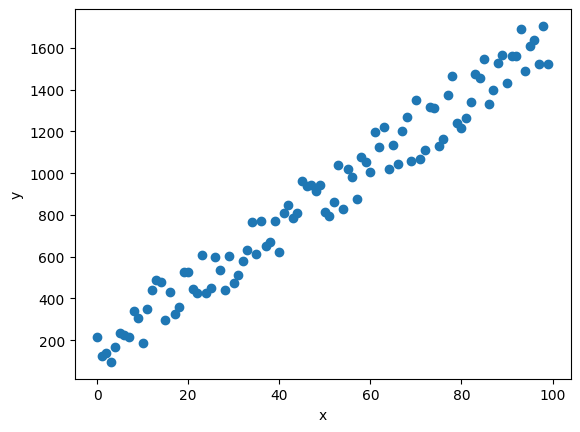

In [23]:
# Do not change the code in this cell
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [24]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / num_samples
    
    return cost

### Q2.1 Implement Linear Regression using Batch Gradient Descent from scratch.  (15 points)


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [25]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])
    
    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')

        if cost[iteration] <= 1.5:
            return params, cost, params_store

        gradient = 0
        # Apply batch gradient descent
        # Update the weights by average of the gradients in each iteration
        for x, y in zip(ip, op):
            gradient += (y - np.dot(params, np.array([1.0, x]))) * np.array([1.0, x])
        params += alpha / num_samples * gradient / num_samples

        iteration += 1
    
    return params, cost, params_store

In [26]:
# Do not change the code in this cell
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)

--------------------------
iteration: 0
cost: 12259916.952539304
--------------------------
iteration: 1
cost: 11335163.000006367
--------------------------
iteration: 2
cost: 10480221.428331155
--------------------------
iteration: 3
cost: 9689821.896554872
--------------------------
iteration: 4
cost: 8959091.937183056
--------------------------
iteration: 5
cost: 8283526.919553174
--------------------------
iteration: 6
cost: 7658962.280755648
--------------------------
iteration: 7
cost: 7081547.85292382
--------------------------
iteration: 8
cost: 6547724.128632023
--------------------------
iteration: 9
cost: 6054200.318088165
--------------------------
iteration: 10
cost: 5597934.062853085
--------------------------
iteration: 11
cost: 5176112.681030618
--------------------------
iteration: 12
cost: 4786135.828313127
--------------------------
iteration: 13
cost: 4425599.467995489
--------------------------
iteration: 14
cost: 4092281.0511396127
--------------------------
itera

### Q2.2 Implement Stochastic Gradient Descent from scratch. (15 points)

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [27]:
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """
    
    # initialize iteration, number of samples, cost and parameter array
    num_samples = len(ip)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])
    
    i = 0
    # Compute the cost and store the params for the corresponding cost
    for x,y in zip(ip, op):
        cost[i] = compute_cost(input_var, output_var, params)
        params_store[:, i] = params
        
        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')
        
        # Apply stochastic gradient descent
        params += alpha / num_samples * (np.array([1.0, x]) * (y - np.dot(params, np.array([1.0, x]))))
        i += 1

            
    return params, cost, params_store

In [28]:
# Do not change the code in this cell
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)

--------------------------
iteration: 0
cost: 13074391.754427891
--------------------------
iteration: 1
cost: 11571666.833268369
--------------------------
iteration: 2
cost: 10933593.692614788
--------------------------
iteration: 3
cost: 9170261.531118503
--------------------------
iteration: 4
cost: 9121239.878560154
--------------------------
iteration: 5
cost: 8796033.94133106
--------------------------
iteration: 6
cost: 8215149.106203932
--------------------------
iteration: 7
cost: 6709342.437888732
--------------------------
iteration: 8
cost: 6605485.924316788
--------------------------
iteration: 9
cost: 6558896.826006211
--------------------------
iteration: 10
cost: 6116319.307575772
--------------------------
iteration: 11
cost: 5838970.6971985735
--------------------------
iteration: 12
cost: 5541879.152795241
--------------------------
iteration: 13
cost: 5380723.603521203
--------------------------
iteration: 14
cost: 5380733.337435417
--------------------------
itera

### Q2.3 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm (5 points)

In [29]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm
batch_ss = 0
for x, y in zip(x_train, y_train):
    y_pred = np.dot(params_store_batch[:, -1], np.array([1.0, x]))
    batch_ss += (y_pred - y) ** 2
RMSE_batch = (batch_ss / len(x_train)) ** 0.5
print('RMSE of BGD: ', RMSE_batch)
stochastic_ss = 0
for x, y in zip(x_train, y_train):
    y_pred = np.dot(params_store[:, -1], np.array([1.0, x]))
    stochastic_ss += (y_pred - y) ** 2
RMSE_stochastic = (stochastic_ss / len(x_train)) ** 0.5
print('RMSE of SGD: ', RMSE_stochastic)

RMSE of BGD:  124.65054805012467
RMSE of SGD:  160.31708657808284


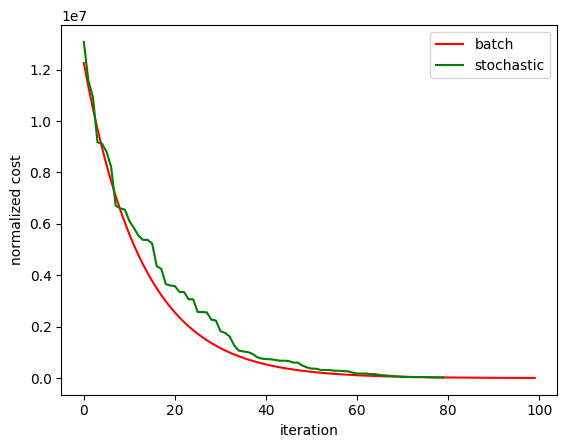

min cost with BGD: 15537.759129196438
min cost with SGD: 27669.237228106558


In [30]:
# Do not change the code in this cell
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### Q2.4 Which linear regression model do you think works best for this data? Explain in brief. (5 points)

Batch Gradient Descent performs better on the given dataset, which has a lower root mean squared error and cost.
Batch Gradient Descent is great for convex or relatively smooth error manifolds. In this case, we move somewhat directly towards an optimum solution.
The graph of cost vs epochs is also quite smooth because we are averaging over all the gradients of training data for a single step. The cost keeps on decreasing over the epochs.
Also, the batch gradient descent are its computational efficiency, it produces a stable error gradient and a stable convergence, which typically reaches the optimal or convergence faster.

### Q3. Linear Regression Analytical Problem (10 points)
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

y_hat = h(x) = w0x0 + w1x1 + w2x2

initialize w0 = 0, w1 = 0, w2 = 0
learning rate = 0.1
stop when SSE < 1.5

Iteration 1:

In [31]:
y_hat0 = 0 + 0 * 0 + 0 * 0
y_hat1 = 0 + 0 * 0 + 0 * 1
y_hat2 = 0 + 0 * 1 + 0 * 0
y_hat3 = 0 + 0 * 1 + 0 * 1
SSE = (y_hat0 - 0)**2 + (y_hat1 - 1.5)**2 + (y_hat2 - 2)**2 + (y_hat3 - 2.5)**2
print('SSE: ', SSE)
print('SSE > 1.2') if SSE > 1.2 else print('Stop')

SSE:  12.5
SSE > 1.2


In [32]:
s0 = (y_hat0 - 0) + (y_hat1 - 1.5) + (y_hat2 - 2) + (y_hat3 - 2.5)
s1 = (y_hat0 - 0) * 0 + (y_hat1 - 1.5) * 0 + (y_hat2 - 2) * 1 + (y_hat3 - 2.5) * 1
s2 = (y_hat0 - 0) * 0 + (y_hat1 - 1.5) * 1 + (y_hat2 - 2) * 0 + (y_hat3 - 2.5) * 1
w0 = 1 - 0.1 / 4 * s0
w1 = 1 - 0.1 / 4 * s1
w2 = 1 - 0.1 / 4 * s2
print(f'w0 = {w0}, w1 = {w1}, w2 = {w2}')

w0 = 1.15, w1 = 1.1125, w2 = 1.1


Iteration 2:

In [33]:
y_hat0 = w0 + w1 * 0 + w2 * 0
y_hat1 = w0 + w1 * 0 + w2 * 1
y_hat2 = w0 + w1 * 1 + w2 * 0
y_hat3 = w0 + w1 * 1 + w2 * 1
SSE = (y_hat0 - 0)**2 + (y_hat1 - 1.5)**2 + (y_hat2 - 2)**2 + (y_hat3 - 2.5)**2
print('SSE: ', SSE)
print('SSE > 1.2') if SSE > 1.2 else print('Stop')

SSE:  2.6978125000000004
SSE > 1.2


In [34]:
s0 = (y_hat0 - 0) + (y_hat1 - 1.5) + (y_hat2 - 2) + (y_hat3 - 2.5)
s1 = (y_hat0 - 0) * 0 + (y_hat1 - 1.5) * 0 + (y_hat2 - 2) * 1 + (y_hat3 - 2.5) * 1
s2 = (y_hat0 - 0) * 0 + (y_hat1 - 1.5) * 1 + (y_hat2 - 2) * 0 + (y_hat3 - 2.5) * 1
w0 = 1 - 0.1 / 4 * s0
w1 = 1 - 0.1 / 4 * s1
w2 = 1 - 0.1 / 4 * s2
print(f'w0 = {w0}, w1 = {w1}, w2 = {w2}')

w0 = 0.924375, w1 = 0.971875, w2 = 0.9596875


Iteration 3:

In [35]:
y_hat0 = w0 + w1 * 0 + w2 * 0
y_hat1 = w0 + w1 * 0 + w2 * 1
y_hat2 = w0 + w1 * 1 + w2 * 0
y_hat3 = w0 + w1 * 1 + w2 * 1
SSE = (y_hat0 - 0)**2 + (y_hat1 - 1.5)**2 + (y_hat2 - 2)**2 + (y_hat3 - 2.5)**2
print('SSE: ', SSE)
print('SSE > 1.2') if SSE > 1.2 else print(f'Converged: y_hat = {w0}x0 + {w1}x1 + {w2}x2')

SSE:  1.1394287109374999
Converged: y_hat = 0.924375x0 + 0.971875x1 + 0.9596875x2
